# **Author prediction**

Through this notebook we will focus on predicting authors, our goal is to recommend the most likely authors for a given research paper based on its title, abstract, and references.
Type of task is similar to multi-label classification.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from wordcloud import WordCloud
from multiprocessing import process
from collections import Counter
import re
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import MultiLabelBinarizer, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import f1_score, precision_score, recall_score
from scipy.sparse import hstack
import nltk
import ast
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tqdm import tqdm
import joblib

In [2]:
# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

# Loading the Data

In [3]:
import zipfile
import pandas as pd
from google.colab import drive

drive.mount('/content/drive')

zip_file_path = '/content/drive/My Drive/dblp-v10.zip'
csv_file_name = 'dblp-v10.csv'

try:
  with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('/content/temp_data')

  df = pd.read_csv(f'/content/temp_data/{csv_file_name}')

except FileNotFoundError:
  print(f"Error: File not found at {zip_file_path}")
except KeyError:
    print(f"Error: File {csv_file_name} not found inside the zip archive.")
except Exception as e:
  print(f"An unexpected error occurred: {e}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Preprocess the authors column
def preprocess_authors(df):
    # Convert string lists to actual lists
    df['authors'] = df['authors'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
    # Normalize names (lowercase, strip whitespace)
    df['authors'] = df['authors'].apply(lambda x: [i.lower() for i in x] if isinstance(x, list) else x)
    return df

def filter_papers(df, min_authors=1, max_authors=7):
    # Filter papers that have between min_authors and max_authors
    df = df[df['authors'].apply(lambda lst: min_authors <= len(lst) <= max_authors)]

    return df


def create_author_matrix(df):
    mlb = MultiLabelBinarizer()
    author_matrix = mlb.fit_transform(df['authors'])
    return author_matrix, mlb

# Preprocess text (abstract + title)
def preprocess_text(df):
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()

    def clean(text):
        text = text.lower() # lowercase the text
        text = re.sub(r'\W+', ' ', text)  # Remove non-word characters
        tokens =  word_tokenize(text)# tokenize
        tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
        return ' '.join(tokens)

    # Cleaning the title and abstract columns
    df['clean_title'] = df['title'].astype(str).apply(clean)
    df['clean_abstract'] = df['abstract'].astype(str).apply(clean)

    # Combine title and abstract for feature extraction
    df['combined_text'] = df['clean_title'] + ' ' + df['clean_abstract']

    return df

# Feature engineering
def create_features(df):
    # TF-IDF for text
    tfidf = TfidfVectorizer(max_features=5000)
    X_text = tfidf.fit_transform(df['combined_text'])

    # One-hot encode venue
    venue_encoder = OneHotEncoder(handle_unknown='ignore')
    X_venue = venue_encoder.fit_transform(df[['venue']])

    # Normalize year
    df['year'] = (df['year'] - df['year'].min()) / (df['year'].max() - df['year'].min())
    X_year = df['year'].values.reshape(-1, 1)

    # Combine all features
    X = hstack([X_text, X_venue, X_year])
    return X, tfidf

# Train and evaluate the model
def train_and_evaluate(X, y):
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    print(X_train.shape)
    print(y_train.shape)
    print(X_test.shape)
    print(y_test.shape)
    # Train a classifier
    # Creating the OneVsRestClassifier using SGDClassifier
    sgd = SGDClassifier(loss='log_loss', max_iter=5, tol=None)
    model = OneVsRestClassifier(sgd)

    # fiting
    model.fit(X_train, y_train)

    # Evaluate
    y_pred = model.predict(X_test)
    print("F1 Score (Micro):", f1_score(y_test, y_pred, average='micro'))
    print("Precision (Micro):", precision_score(y_test, y_pred, average='micro'))
    print("Recall (Micro):", recall_score(y_test, y_pred, average='micro'))

    return model


def get_top_k_predictions(model, X, mlb, k=5):
    """
    Returns a list of top-k predicted authors for each sample.
    Uses decision_function if available, otherwise predict_proba.
    """
    if hasattr(model, "decision_function"):
        scores = model.decision_function(X)
    elif hasattr(model, "predict_proba"):
        scores = model.predict_proba(X)
    else:
        raise AttributeError("Model does not support decision_function or predict_proba.")

    top_k_authors = []
    for score in scores:
        top_indices = score.argsort()[-k:][::-1]
        top_k_authors.append([mlb.classes_[i] for i in top_indices])
    return top_k_authors

# Data exploration

In [6]:
df.shape

(1000000, 8)

In [6]:
df.head()

,abstract,authors,n_citation,references,title,venue,year,id
0,"In this paper, a robust 3D triangular mesh wat...","['S. Ben Jabra', 'Ezzeddine Zagrouba']",50,"['09cb2d7d-47d1-4a85-bfe5-faa8221e644b', '10aa...",A new approach of 3D watermarking based on ima...,international symposium on computers and commu...,2008,4ab3735c-80f1-472d-b953-fa0557fed28b
1,We studied an autoassociative neural network w...,"['Joaquín J. Torres', 'Jesús M. Cortés', 'Joaq...",50,"['4017c9d2-9845-4ad2-ad5b-ba65523727c5', 'b118...",Attractor neural networks with activity-depend...,Neurocomputing,2007,4ab39729-af77-46f7-a662-16984fb9c1db
2,It is well-known that Sturmian sequences are t...,"['Genevi eve Paquin', 'Laurent Vuillon']",50,"['1c655ee2-067d-4bc4-b8cc-bc779e9a7f10', '2e4e...",A characterization of balanced episturmian seq...,Electronic Journal of Combinatorics,2007,4ab3a4cf-1d96-4ce5-ab6f-b3e19fc260de
3,One of the fundamental challenges of recognizi...,"['Yaser Sheikh', 'Mumtaz Sheikh', 'Mubarak Shah']",221,"['056116c1-9e7a-4f9b-a918-44eb199e67d6', '05ac...",Exploring the space of a human action,international conference on computer vision,2005,4ab3a98c-3620-47ec-b578-884ecf4a6206
4,This paper generalizes previous optimal upper ...,"['Efraim Laksman', 'Håkan Lennerstad', 'Magnus...",0,"['01a765b8-0cb3-495c-996f-29c36756b435', '5dbc...",Generalized upper bounds on the minimum distan...,Ima Journal of Mathematical Control and Inform...,2015,4ab3b585-82b4-4207-91dd-b6bce7e27c4e


In [7]:
df["authors"]

,authors
0,"['S. Ben Jabra', 'Ezzeddine Zagrouba']"
1,"['Joaquín J. Torres', 'Jesús M. Cortés', 'Joaq..."
2,"['Genevi eve Paquin', 'Laurent Vuillon']"
3,"['Yaser Sheikh', 'Mumtaz Sheikh', 'Mubarak Shah']"
4,"['Efraim Laksman', 'Håkan Lennerstad', 'Magnus..."
...,...
999995,"['Jeril Kuriakose', 'Sandeep Joshi']"
999996,"['Anh Khoa Bui', 'ZheKai Xiao', 'Liter Siek']"
999997,"['Sarah E. Ballinger', 'Thomas A. Adams']"
999998,"['Ben London', 'Bert Huang', 'Lise Getoor']"


In [8]:
# Check for null values in each column of the DataFram
df.isnull().sum()


,0
abstract,172467
authors,2
n_citation,0
references,124417
title,0
venue,177755
year,0
id,0


In [9]:
# Check the data type of each column
df.dtypes


,0
abstract,object
authors,object
n_citation,int64
references,object
title,object
venue,object
year,int64
id,object


In [10]:
# Display some descriptive statistics for numerical columns
print(df.describe())


           n_citation            year
count  1000000.000000  1000000.000000
mean        36.000933     2009.447896
std        190.784498        7.032415
min          0.000000     1937.000000
25%          0.000000     2006.000000
50%          7.000000     2011.000000
75%         50.000000     2015.000000
max      42508.000000     2017.000000


In [11]:
# Numerical columns
numerical_cols = df.select_dtypes(include=np.number).columns.tolist()
print("Numerical columns:", numerical_cols)

# Categorical columns
categorical_cols = df.select_dtypes(exclude=np.number).columns.tolist()
print("Categorical columns:", categorical_cols)


Numerical columns: ['n_citation', 'year']
Categorical columns: ['abstract', 'authors', 'references', 'title', 'venue', 'id']


# Data cleaning and preparation

In [7]:
# keeping a copy of the original datafram
df_original = df.copy()

In [5]:
df.dropna(inplace=True)

In [14]:
df.shape

(693622, 8)

In [6]:
#Preprocess authors (convert string lists to actual lists and normalizing the text of authors
df = preprocess_authors(df)

In [7]:
# Check for empty author lists
empty_author_instances = df[df['authors'].apply(lambda x: len(x) == 0)]
print(f"Number of instances with empty author lists: {len(empty_author_instances)}")

if not empty_author_instances.empty:
    print("Indices of instances with empty author lists:")
    print(empty_author_instances.index.tolist())


Number of instances with empty author lists: 0


In [8]:
#delete instances with empty list of authors
dfNoEmpty = df[df['authors'].apply(lambda x: isinstance(x, list) and len(x) > 0)]


# Data analysis

## 1. Unique Authors and Frequency Distribution


Total unique authors: 741291
Top 20 most prolific authors:
                author  nbPapers
3874          wei wang       761
4495         wei zhang       520
1804         lei zhang       463
7590          yang liu       447
2536            wei li       444
2916       lajos hanzo       429
6132          jun wang       422
6166         jun zhang       369
5773          lei wang       363
3764           wen gao       356
2670           wei liu       350
2498            xin li       326
7300          xin wang       322
461    thomas s. huang       321
30273         wei chen       318
4801            jie wu       313
12960         li zhang       310
13506        jing wang       309
731          jie zhang       308
7073          yu zhang       304
20 least prolific authors:
                        author  nbPapers
385253            umair qidwai         1
385251            yu-jen hsieh         1
385246             andrew ward         1
385242      peter robert woods         1
385241  michelle

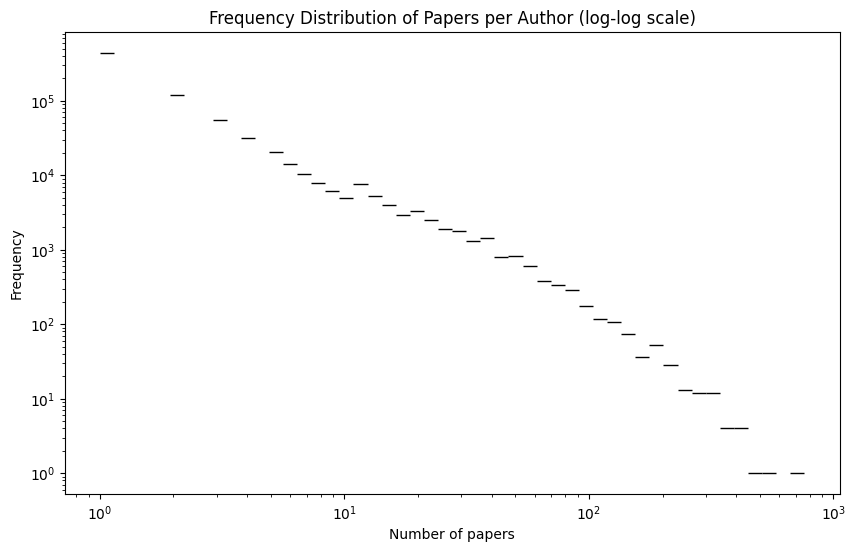

In [18]:
# nb of unique authors
all_authors = [author for authors_list in dfNoEmpty['authors'] for author in authors_list]
unique_authors = set(all_authors)
print("Total unique authors:", len(unique_authors))

# count number of papers per author
author_counts = Counter(all_authors)
author_freq_df = pd.DataFrame(author_counts.items(), columns=['author', 'nbPapers'])
author_freq_df = author_freq_df.sort_values('nbPapers', ascending=False)
print("Top 20 most prolific authors:")
print(author_freq_df.head(20))

print("20 least prolific authors:")
print(author_freq_df.tail(20))

# Histogram of frequency distribution (log-log scale)
plt.figure(figsize=(10,6))
sns.histplot(author_freq_df['nbPapers'], bins=50, log_scale=(True, True))
plt.title("Frequency Distribution of Papers per Author (log-log scale)")
plt.xlabel("Number of papers")
plt.ylabel("Frequency")
plt.show()

## 2. Number of Authors per Paper


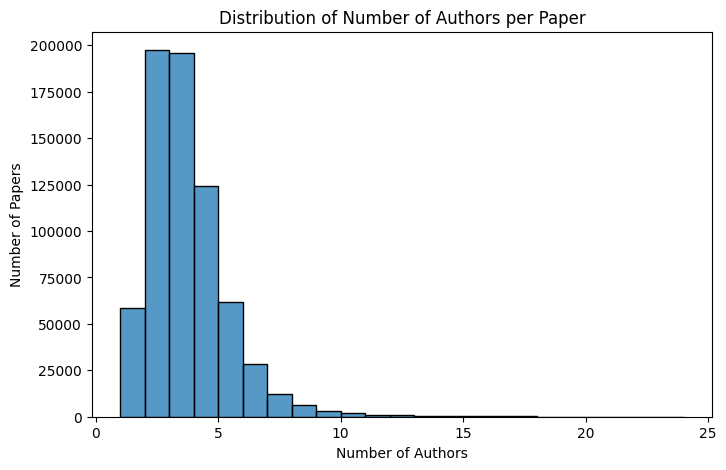

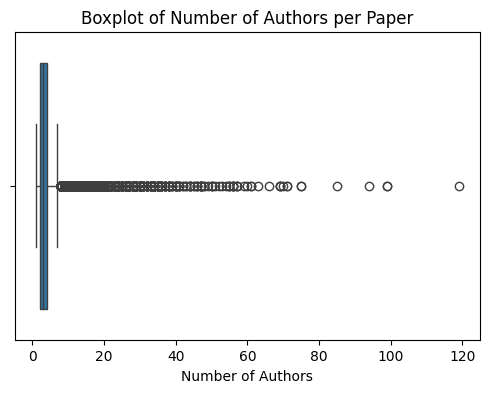

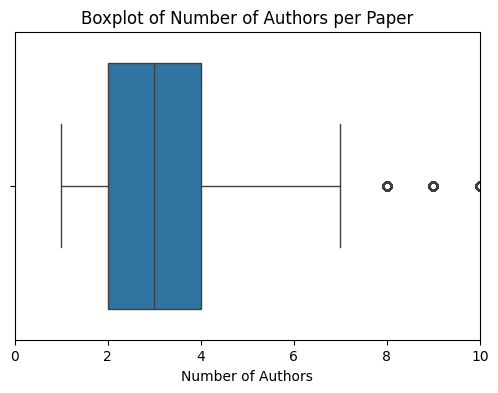

Summary statistics for number of authors per paper:
count    693622.000000
mean          3.258355
std           1.852833
min           1.000000
25%           2.000000
50%           3.000000
75%           4.000000
max         119.000000
Name: num_authors, dtype: float64


In [19]:
# number of authors per paper
dfNoEmpty['num_authors'] = dfNoEmpty['authors'].apply(len)

#  number of authors per paper
plt.figure(figsize=(8,5))
sns.histplot(dfNoEmpty['num_authors'], bins=range(1, 25), kde=False)
plt.title("Distribution of Number of Authors per Paper")
plt.xlabel("Number of Authors")
plt.ylabel("Number of Papers")
plt.show()

# Boxplot
plt.figure(figsize=(6,4))
sns.boxplot(x=dfNoEmpty['num_authors'])
plt.title("Boxplot of Number of Authors per Paper")
plt.xlabel("Number of Authors")
plt.show()

# zoom in the boxplot
plt.figure(figsize=(6,4))
sns.boxplot(x=dfNoEmpty['num_authors'])
plt.title("Boxplot of Number of Authors per Paper")
plt.xlabel("Number of Authors")
plt.xlim(0, 10)
plt.show()


# Summary statistics
print("Summary statistics for number of authors per paper:")
print(dfNoEmpty['num_authors'].describe())

## 3. Co-Authorship Analysis


Co-authorship network: Nodes = 741291 Edges = 2810307


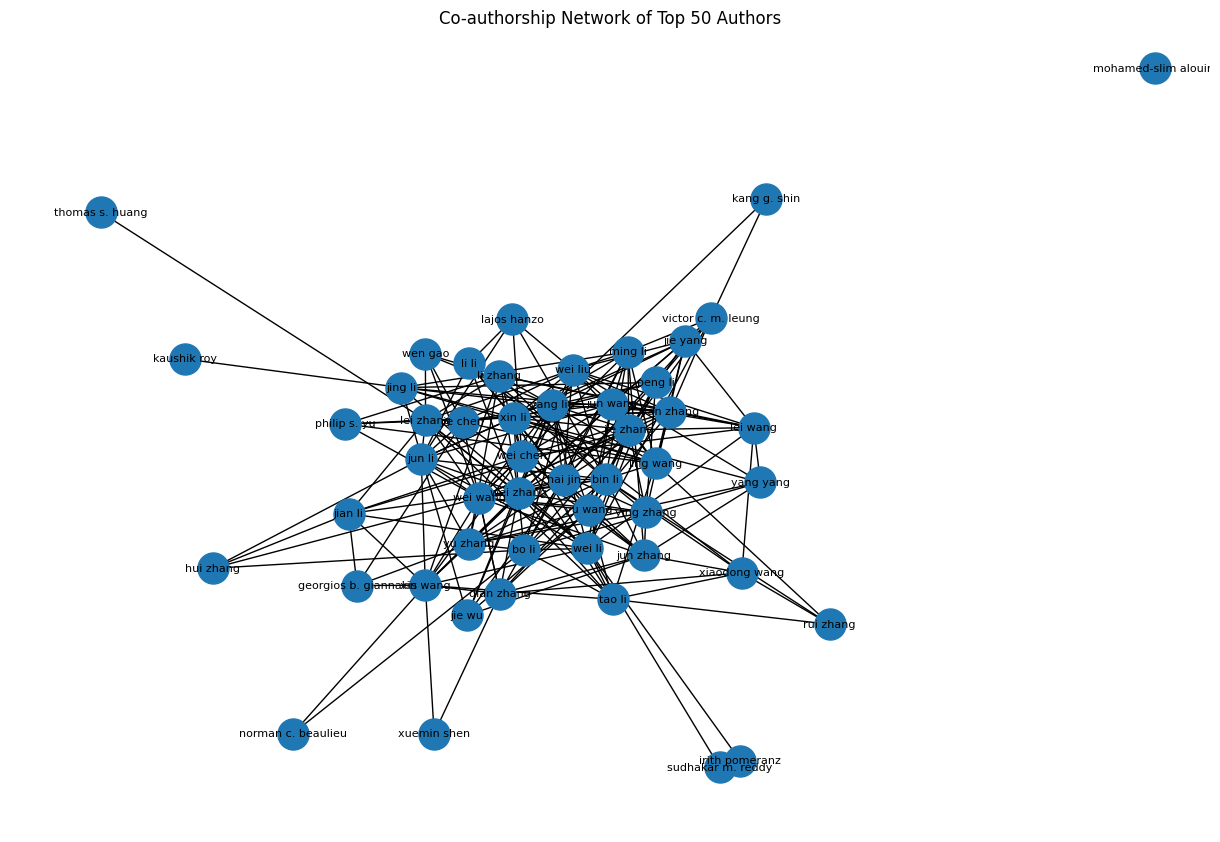

Top 20 authors by degree centrality:
wei wang 0.0021017415586342724
wei li 0.001612054661468521
wei zhang 0.0014420806971630535
yang liu 0.0014366846982962133
lei wang 0.0013719327118941304
lei zhang 0.0012478247379568048
jun wang 0.0011655357552374913
wei liu 0.0010994347691186985
wei chen 0.0010319847832831954
xin li 0.0010252397846996452
li zhang 0.0009861187929150535
yu zhang 0.000976675794898083
jun zhang 0.0009726287957479528
jing wang 0.0009658837971644026
yang yang 0.0009604877982975623
yan zhang 0.0009456488014137517
yu wang 0.0009240648059463907
jun li 0.0009200178067962605
jing li 0.0009159708076461303
bo li 0.0008674068178445681


In [20]:
# Building a co-authorship network
G = nx.Graph()
# Add nodes
for author in unique_authors:
    G.add_node(author)

# Add edges: for each paper, add an edge between every pair of authors
for authors_list in dfNoEmpty['authors']:
    for i in range(len(authors_list)):
        for j in range(i+1, len(authors_list)):
            a1 = authors_list[i]
            a2 = authors_list[j]
            if G.has_edge(a1, a2):
                G[a1][a2]['weight'] += 1
            else:
                G.add_edge(a1, a2, weight=1)

print("Co-authorship network: Nodes =", G.number_of_nodes(), "Edges =", G.number_of_edges())

# Plot a subgraph of the top 50 most prolific authors
top_authors = author_freq_df.head(50)['author'].tolist()
subG = G.subgraph(top_authors)
plt.figure(figsize=(12,8))
pos = nx.spring_layout(subG, k=0.5)
nx.draw(subG, pos, with_labels=True, node_size=500, font_size=8)
plt.title("Co-authorship Network of Top 50 Authors")
plt.show()

# Compute degree centrality (top 10)
degree_centrality = nx.degree_centrality(G)
top_degree = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:20]
print("Top 20 authors by degree centrality:")
for author, centrality in top_degree:
    print(author, centrality)


### Comments:

#### **1. Large Author Pool with a Long-Tail Distribution**
- **741,291 Unique Authors:** The dataset includes a vast number of contributors, most of whom appear only a few times.  
- **Top 20 Prolific Authors:** Each has over 300 publications (e.g., Wei Wang at 761), indicating a small core of highly active researchers.  

**Implication for Classification (prediction):**  
- The label space is enormous and **long-tailed**, with a tiny fraction of authors publishing prolifically and a large number publishing infrequently. This poses challenges in building a stable multi-label classification model, as many labels (authors) have very few samples.

**Possible Actions:**
  
We can consider excluding authors with very few papers to reduce label noise.  

#### **2. Typical Collaboration Size and Outliers**
- **Mean:** ~3 authors per paper.  
- **Median:** 3 authors.  
- **Right-Skewed Distribution:** Most papers have 2–4 authors, but some have many more.  
- **Maximum:** 119 authors on a single paper, likely large multi-institutional collaborations.  
- **Outliers:** Papers with 7+ authors are flagged as outliers in the boxplot.

**Implication for Classification:**  
- Papers with a very large number of authors create **high-dimensional target vectors** for multi-label classification (one paper might be associated with dozens of authors).  
- The presence of such extreme outliers can skew training and negatively impact performance, especially if these cases are relatively rare and require special handling.

#### **3. Decision: Removing Outlier Papers for Multi-Label Classification**

Given the complexities of handling:
- A **massive label space** (hundreds of thousands of authors),
- **Outliers** with 7+ authors per paper,

we propose the following **practical decision** to improve the feasibility of multi-label classification:

1. **Exclude Papers with ≥7 Authors:**  
   - These papers are outliers that can disproportionately inflate the complexity of the model.  
   - By removing them, we reduce the maximum label dimensionality per sample.  
   - While this excludes some large-scale collaborations, it yields a more homogeneous subset of papers with typical collaboration sizes (2–6 authors).

2. **Filter Very Rare Authors:**  
   - If an author appears only once, it is extremely difficult for the model to learn meaningful patterns about that author.  
   - Removing authors with minimal activity can further reduce noise and the size of the label space.

**Pros of This Approach**  
- **Reduced Model Complexity:** Fewer extreme cases (papers with dozens of authors) and fewer single-appearance labels.  
- **More Reliable Training:** The model can focus on the most common collaboration patterns, improving generalization.

**Cons of This Approach**  
- **Loss of Data:** Excluding large-collaboration papers removes potentially interesting cases (e.g., high-impact studies).  
- **Potential Bias:** Filtering rare authors may overlook emerging researchers or niche fields.


## 4. Assess Impact on Citations (Does Collaboration Size Correlate with Citations?)

We define “high-author” papers as those with 7 or more authors (based on your outlier threshold)


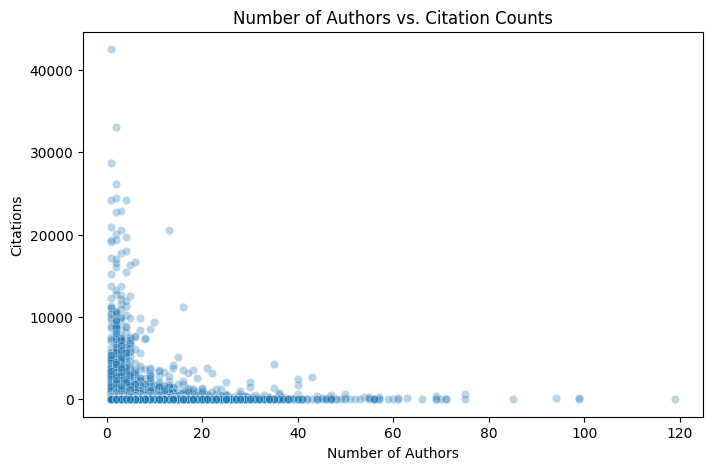

Correlation between number of authors and citations: -0.001


<ipython-input-21-9fc1b74a7d56>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='num_authors', y='n_citation', data=df_author_bins, palette='viridis')


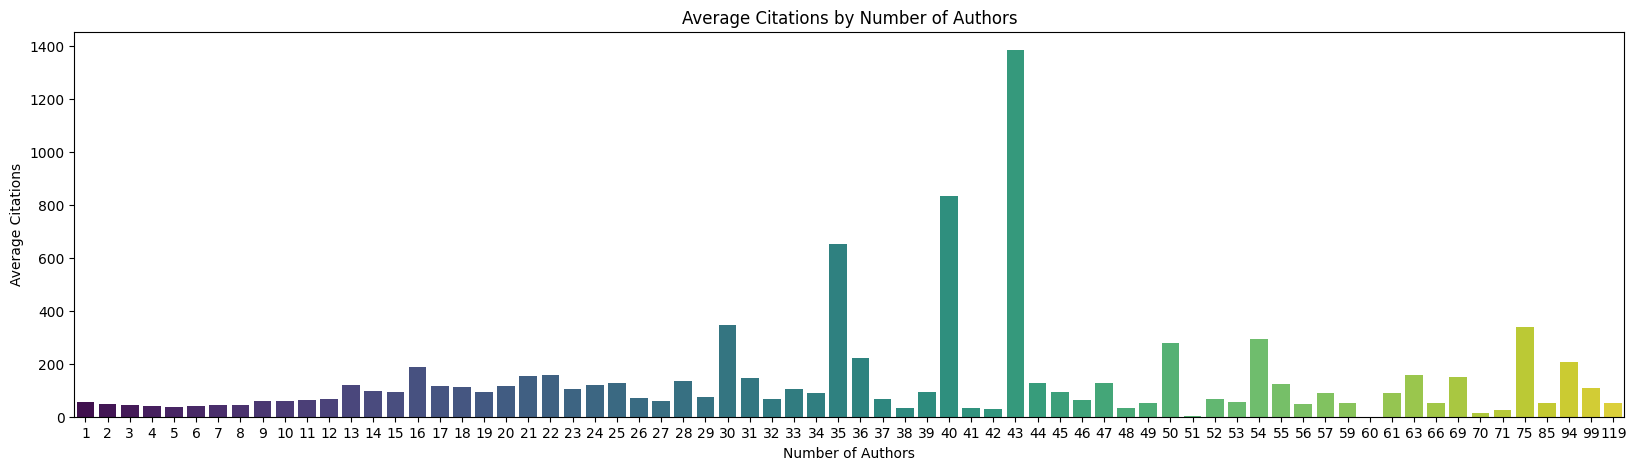

In [21]:
# a simple scatter plot of num_authors vs. citations
plt.figure(figsize=(8,5))
sns.scatterplot(x='num_authors', y='n_citation', data=dfNoEmpty, alpha=0.3)
plt.title("Number of Authors vs. Citation Counts")
plt.xlabel("Number of Authors")
plt.ylabel("Citations")
plt.show()

# check the  correlation
corr_value = dfNoEmpty[['num_authors', 'n_citation']].corr().iloc[0,1]
print(f"Correlation between number of authors and citations: {corr_value:.3f}")

# grouping the papers by author count and computing the average citations
df_author_bins = dfNoEmpty.groupby('num_authors')['n_citation'].mean().reset_index()
plt.figure(figsize=(20,5))
sns.barplot(x='num_authors', y='n_citation', data=df_author_bins, palette='viridis')
plt.title("Average Citations by Number of Authors")
plt.xlabel("Number of Authors")
plt.ylabel("Average Citations")
plt.show()


### Comments:
**1.Number of Authors vs. Citation Counts**  
The scatter plot shows how citation counts vary across papers with different numbers of authors. Most papers cluster around 1–10 authors, and there is no clear linear trend indicating that “more authors” always lead to higher citations. A few high-citation outliers exist at both low and high author counts, suggesting that while large collaborations can attract many citations, smaller teams can also produce highly cited work. Overall, the relationship appears weak or non-linear, indicating that collaboration size is just one factor influencing a paper’s impact.

**2. Average Citations by Number of Authors**  
In the bar chart illustrating average citations for each exact number of authors, the distribution is quite uneven. There are notable spikes at certain author counts—likely reflecting small clusters of highly cited papers within specific fields. Meanwhile, many other author counts show only moderate citation averages. This irregular pattern reinforces the idea that large collaborations sometimes yield highly cited papers, but it is not a universal rule.

### **Decision to Include Papers with 1–7 Authors Only (no outliers)**
These two plots highlight that while large-author papers can occasionally be very highly cited, they are relatively rare and tend to behave as outliers. For a multi-label classification task focusing on typical collaboration patterns, excluding papers with more than 7 authors reduces complexity and outlier influence. This trade-off removes a small subset of high-author papers that might skew the dataset, simplifying model training while still retaining the vast majority of “standard” papers where 1–7 authors is the norm.

# Data preprocessing

In [37]:
df_filtered = filter_papers(dfNoEmpty, min_authors=1, max_authors=7)

In [38]:
df_filtered.shape

(678287, 8)

In [39]:
print("Total unique authors in df_filtered:", len(set([author for authors_list in df_filtered['authors'] for author in authors_list])))


Total unique authors in df_filtered: 685983


In [40]:
#  delete from df_filtered the lines with authors is an emplty list
df_filtered = df_filtered[df_filtered['authors'].apply(lambda x: len(x) > 0)]


In [41]:
dfNoEmpty.shape, df_filtered.shape

((693622, 8), (678287, 8))

In [27]:
df_filtered['authors']

,authors
0,"[s. ben jabra, ezzeddine zagrouba]"
1,"[joaquín j. torres, jesús m. cortés, joaquín m..."
2,"[genevi eve paquin, laurent vuillon]"
3,"[yaser sheikh, mumtaz sheikh, mubarak shah]"
4,"[efraim laksman, håkan lennerstad, magnus nils..."
...,...
999991,"[katharina prinz, andreas steinboeck, martin k..."
999993,"[yang long, li liu, ling shao]"
999994,"[jingbo meng, lourdes martinez, amanda j. holm..."
999997,"[sarah e. ballinger, thomas a. adams]"


In [13]:
df_sampled = df_filtered.sample(n=10000, random_state=42)  # random_state for reproducibility


In [19]:
# Create author matrix (labels)
author_matrix, mlb = create_author_matrix(df_sampled)

In [20]:
author_matrix, mlb

(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]),
 MultiLabelBinarizer())

In [21]:
author_matrix.shape

(10000, 27892)

In [43]:
# preprocess text
df_sampled = preprocess_text(df_sampled)

In [ ]:
# save the preproced dataframe to a new csv file
df_filtered.to_csv('preprocessed_data.csv', index=False)

In [44]:
# Step 6: Create features
X, tfidf = create_features(df_sampled)

In [45]:
# Verify shapes
print("Shape of X:", X.shape)
print("Shape of author_matrix:", author_matrix.shape)
print("Rows in df_filtered:", df_filtered.shape[0])

Shape of X: (10000, 6705)
Shape of author_matrix: (10000, 27892)
Rows in df_filtered: 678287


In [46]:
import joblib

# Cache the TF-IDF vectorizer, the feature matrix, and the preprocessed DataFrame.
joblib.dump(tfidf, 'tfidf_vectorizer.pkl')
joblib.dump(X, 'features_X.pkl')
joblib.dump(df_filtered, 'df_filtered.pkl')


['df_filtered.pkl']

### Using  BERT tokenzation and classification

In [47]:
pip install transformers torch pandas numpy scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 58.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 28.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 49.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [48]:
df_sampled.columns

Index(['abstract', 'authors', 'n_citation', 'references', 'title', 'venue',
       'year', 'id', 'clean_title', 'clean_abstract', 'combined_text'],
      dtype='object')

In [ ]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    df_sampled['combined_text'], author_matrix, test_size=0.2, random_state=42
)

from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize text (title + abstract)
train_encodings = tokenizer(
    X_train.tolist(),
    truncation=True,
    padding=True,
    max_length=512  # BERT's max input length
)
test_encodings = tokenizer(
    X_test.tolist(),
    truncation=True,
    padding=True,
    max_length=512
)

import torch
from torch.utils.data import Dataset

class AuthorDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.encodings['input_ids'][idx]),
            'attention_mask': torch.tensor(self.encodings['attention_mask'][idx]),
            'labels': torch.tensor(self.labels[idx], dtype=torch.float)  # Multi-label requires float
        }

    def __len__(self):
        return len(self.labels)

train_dataset = AuthorDataset(train_encodings, y_train)
test_dataset = AuthorDataset(test_encodings, y_test)

from transformers import BertForSequenceClassification, Trainer, TrainingArguments

model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=len(mlb.classes_),  # Number of authors
    problem_type="multi_label_classification"
)

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=4,  # Reduce if OOM errors
    per_device_eval_batch_size=4,
    logging_dir='./logs',
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

trainer.train()

from sklearn.metrics import f1_score, precision_score, recall_score

# Predict
predictions = trainer.predict(test_dataset)
preds = torch.sigmoid(torch.tensor(predictions.predictions)).numpy() > 0.5  # Threshold

# Calculate metrics
print("Micro F1:", f1_score(y_test, preds, average='micro'))
print("Precision:", precision_score(y_test, preds, average='micro'))
print("Recall:", recall_score(y_test, preds, average='micro'))

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: hafismellissa (hafismellissa-communaut-paris-saclay) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


wandb: WARNING Serializing object of type dict that is 1310800 bytes
wandb: WARNING Serializing object of type dict that is 961280 bytes


Step,Training Loss


### Training method 1: Full batch (with a baseline model)
the shapes are too huge so it's not realy possible to do a full batch traininh

In [ ]:
import
def train_and_evaluate_dense(X, y):
    # Split data into train/test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    # Hyperparameter tuning: You can adjust batch_size, max_iter, or learning rate here.
    sgd = SGDClassifier(
        loss='log_loss',          # Logistic regression
        penalty='l2',
        max_iter=1,               # One epoch per batch
        learning_rate='adaptive',
        eta0=0.1,
        random_state=42
    )
    model = OneVsRestClassifier(sgd)

    # Train the model on the full dataset
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Evaluate using common metrics
    print("F1 Score (Micro):", f1_score(y_test, y_pred, average='micro'))
    print("Precision (Micro):", precision_score(y_test, y_pred, average='micro'))
    print("Recall (Micro):", recall_score(y_test, y_pred, average='micro'))

    return model

# Train using dense arrays
model = train_and_evaluate_dense(X, author_matrix)


### Methode 2: with batch learning (baseline model)
but i have essues with this method and i couldn't to fixe them

In [ ]:
def train_and_evaluate_batch(X, y, batch_size=1000, test_batch_size=5000, checkpoint_interval=100):
    # Split data into train/test indices
    indices = np.arange(X.shape[0])
    train_idx, test_idx = train_test_split(indices, test_size=0.3, random_state=42)

    # Hyperparameter tuning: You can adjust batch_size, max_iter, or learning rate here.
    sgd = SGDClassifier(
        loss='log_loss',          # Logistic regression
        penalty='l2',
        max_iter=1,               # One epoch per batch
        learning_rate='adaptive',
        eta0=0.1,
        random_state=42
    )
    model = OneVsRestClassifier(sgd)

    # Initialize MultiLabelBinarizer for multi-label classification
    mlb = MultiLabelBinarizer()
    # Convert the sparse matrix to a dense array before fitting MultiLabelBinarizer.
    # Then, convert each row to a list of author indices.
    y_dense = y.toarray()
    y_iterable = [np.where(row)[0].tolist() for row in y_dense]
    mlb.fit(y_iterable)  # Fit to get all possible classes
    classes = mlb.classes_  # Get all unique classes

    # Training loop with progress logging and checkpointing
    for i in tqdm(range(0, len(train_idx), batch_size), desc="Training batches"):
        batch_indices = train_idx[i:i+batch_size]
        X_batch = X[batch_indices].tocsr()
        y_batch = y[batch_indices].toarray()  # Convert sparse to dense array for training

        # Use the fitted MultiLabelBinarizer to transform labels for partial_fit
        y_batch_transformed = mlb.transform( [np.where(row)[0].tolist() for row in y_batch] )

        model.partial_fit(X_batch, y_batch_transformed, classes=classes) # Pass transformed labels


        # Save a checkpoint every checkpoint_interval batches
        if ((i // batch_size) + 1) % checkpoint_interval == 0:
            checkpoint_filename = f'model_checkpoint_batch_{(i // batch_size) + 1}.pkl'
            joblib.dump(model, checkpoint_filename)
            print(f"Checkpoint saved: {checkpoint_filename}")

    # Evaluation loop with progress logging
    y_true_batches = []
    y_pred_batches = []
    for i in tqdm(range(0, len(test_idx), test_batch_size), desc="Evaluating batches"):
        batch_indices = test_idx[i:i+test_batch_size]
        X_batch = X[batch_indices].tocsr()
        y_batch_true = y[batch_indices].toarray()

        # Transform true labels for evaluation using the same MultiLabelBinarizer
        y_batch_true_transformed = mlb.transform([np.where(row)[0].tolist() for row in y_batch_true])

        y_batch_pred = model.predict(X_batch)
        y_true_batches.append(y_batch_true_transformed) # Append transformed true labels
        y_pred_batches.append(y_batch_pred)

    y_true = np.vstack(y_true_batches)
    y_pred = np.vstack(y_pred_batches)

    print("F1 Score (Micro):", f1_score(y_true, y_pred, average='micro'))
    print("Precision (Micro):", precision_score(y_true, y_pred, average='micro'))
    print("Recall (Micro):", recall_score(y_true, y_pred, average='micro'))

    return model

In [ ]:
# Step 1: Filter authors
author_counts = np.array(author_matrix_sparse.sum(axis=0)).ravel()
top_author_indices = np.argsort(-author_counts)[:1000]
author_matrix_filtered = author_matrix_sparse[:, top_author_indices].tocsc()

# Step 2: Remove empty papers
non_empty_mask = author_matrix_filtered.sum(axis=1) > 0
non_empty_indices = np.where(non_empty_mask)[0]  # Get 1D array of indices
author_matrix_filtered = author_matrix_filtered[non_empty_indices]
X_filtered = X_sparse[non_empty_indices]

# Step 3: Convert labels to dense
author_matrix_dense = author_matrix_filtered.toarray()

# Step 4: Train with classes initialized
classes = np.arange(author_matrix_dense.shape[1])
model = train_and_evaluate_batch3(X_filtered, author_matrix_dense, classes)

In [ ]:
# Example prediction
example_idx = 0
example_text = df.iloc[example_idx]['text']
example_venue = df.iloc[example_idx]['venue']
example_year = df.iloc[example_idx]['year']

# TF-IDF for text
tfidf = TfidfVectorizer(max_features=5000)
# One-hot encode venue
venue_encoder = OneHotEncoder(handle_unknown='ignore')

example_features = hstack([
    tfidf.transform([example_text]),
    venue_encoder.transform([[example_venue]]),
    np.array([[example_year]])
])
predicted_authors = model.predict(example_features)
predicted_author_names = mlb.inverse_transform(predicted_authors)
print(f"Predicted authors for example paper: {predicted_author_names}")

## An advanced model

For advanced models we can try the methods:
- specter
- SCIBERT

In [ ]:
! pip install sentence-transformers

In [ ]:
df_filtered.columns

In [ ]:
from sentence_transformers import SentenceTransformer

# Load the SPECTER model (suitable for scientific texts)
model = SentenceTransformer('allenai-specter')

# Generate embeddings for the combined text
# Note: For large datasets, you might want to process in batches.
embeddings = model.encode(df_filtered['combined_text'].tolist(), show_progress_bar=True)

# Convert embeddings to a NumPy array
import numpy as np
X_embeddings = np.array(embeddings)

print("Shape of Transformer Embeddings:", X_embeddings.shape)
